## 1. Datenimport und Initialisierung

In diesem Abschnitt werden die OpenJur-Urteilstexte aus dem Datenverzeichnis eingelesen und die technische Datenbasis für die nachfolgenden Verarbeitungsschritte geschaffen. Dazu werden die benötigten Bibliotheken importiert und die verfügbaren Textdateien identifiziert.


### 1.1 Import der benötigten Bibliotheken

Zu Beginn werden die für die weitere Verarbeitung erforderlichen Python-Bibliotheken importiert. Diese umfassen Funktionen für Dateizugriffe, reguläre Ausdrücke, Datenverarbeitung mit Pandas sowie den Export der Ergebnisse im JSON-Format.

In [32]:
import os
import re
import json
import pandas as pd

### 1.2 Einlesen der OpenJur-Urteilstexte 

Die OpenJur-Urteilstexte werden aus einem parametrierten Datenverzeichnis (DATA_DIR) eingelesen. Jedes Urteil liegt als separate Textdatei vor und wird über den Dateinamen eindeutig einer Fallkennung (case_id) zugeordnet. Zur Sicherstellung einer konsistenten Verarbeitung werden die identifizierten Textdateien sortiert. Die eingelesenen Texte bilden die Rohdatenbasis für alle nachfolgenden Verarbeitungs- und Analyse­schritte.

In [41]:
DATA_DIR = "../data/Gerichtsurteile_Openjur"

files = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith(".txt")])

print("Pfad:", os.path.abspath(DATA_DIR))
print("Anzahl .txt:", len(files))
print("Erste 10 Dateien:", files[:10])


Pfad: c:\Users\humme\OneDrive\Dokumente\Uni Ulm\ds_law\backend\data\Gerichtsurteile_Openjur
Anzahl .txt: 2375
Erste 10 Dateien: ['2090187.txt', '2112111.txt', '2112115.txt', '2112117.txt', '2112118.txt', '2112119.txt', '2112121.txt', '2112123.txt', '2124977.txt', '2126821.txt']


---

## 2. Extraktion relevanter Urteilsbestandteile und Selektion der Landgerichtsurteile

In diesem Abschnitt werden die eingelesenen Urteilstexte weiterverarbeitet, um für die nachfolgende Analyse relevante Textbestandteile gezielt zu extrahieren. Hierzu zählen insbesondere ein begrenzter Kopfbereich zur Voranalyse sowie der Tenor als Kern der gerichtlichen Entscheidung. Die strukturierte Aufbereitung dieser Textsegmente bildet die Grundlage für Filter-, Klassifikations- und Extraktionsschritte in den folgenden Abschnitten.

### 2.1 Aufbau des DataFrames und Extraktion eines Kopfbereichs

Die eingelesenen Texte werden in einem DataFrame (`df`) gespeichert. Zusätzlich wird ein begrenzter Kopfbereich (`head`) aus den ersten Zeichen extrahiert, da strukturelle Metadaten wie Gerichtstyp, Entscheidungsart und Zitierzeilen typischerweise am Anfang des Dokuments auftreten. Dieser Kopfbereich dient als effizienter Suchraum für die spätere Identifikation von Landgerichtsurteilen.


In [3]:
rows = []
for fn in files:
    case_id = fn.replace(".txt", "")
    path = os.path.join(DATA_DIR, fn)
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    rows.append({"case_id": case_id, "text": text})

df = pd.DataFrame(rows)
print("Gesamt eingelesen:", len(df))


Gesamt eingelesen: 2375


In [4]:
HEAD_CHARS = 8000
df["head"] = df["text"].astype(str).str.slice(0, HEAD_CHARS)

print("Head-Länge (Beispiel):", len(df.loc[0, "head"]))


Head-Länge (Beispiel): 8000


### 2.2 Extraktion des Tenors

Der Tenor enthält die eigentliche gerichtliche Entscheidung und ist daher für die inhaltliche Bewertung besonders relevant. Mithilfe regulärer Ausdrücke wird der Textabschnitt zwischen der Überschrift „Tenor“ und den nachfolgenden Abschnitten (z. B. „Tatbestand“ oder „Gründe“) extrahiert und in einer separaten Spalte gespeichert.

In [ ]:
def extract_tenor(text: str) -> str:
    if not isinstance(text, str):
        return ""

    m_start = re.search(r"\bTenor\b", text, flags=re.IGNORECASE)
    if not m_start:
        return ""

    start = m_start.end()

    # Das Suchfenster nach dem Tenor wird begrenzt (robuster gegen Navigation)
    window = text[start:start + 20000]

    m_end = re.search(
        r"\b(Tatbestand|Gründe|Gruende|Entscheidungsgründe|Entscheidungsgruende)\b",
        window,
        flags=re.IGNORECASE
    )

    end = start + m_end.start() if m_end else min(len(text), start + 8000)
    return text[start:end].strip()
df["tenor"] = df["text"].apply(extract_tenor)
print("Tenor vorhanden:", (df["tenor"].str.len() > 0).sum(), "von", len(df))


Tenor vorhanden: 2362 von 2375


### 2.3 Identifikation von Landgerichtsurteilen (LG)

Die Selektion der Landgerichtsurteile erfolgt anhand einer OpenJur-spezifischen Zitierzeile im Kopfbereich (Regex: „Einfach“ gefolgt von „LG“). Auf dieser Grundlage wird eine boolesche Variable erzeugt und der Teilkorpus df_lg gebildet. Die Selektion dient als heuristischer Vorfilter auf Basis der OpenJur-Zitierzeile; eine inhaltliche Absicherung des Gerichtstyps erfolgt später über die LLM-basierte Extraktion.

In [ ]:
pattern_zitierung_lg = r"Einfach\s*\n\s*LG"

df["is_landgericht"] = df["head"].str.contains(pattern_zitierung_lg, regex=True, na=False)

# Erstellung des sauberen DataFrames mit echten LG-Urteilen
df_lg = df[df["is_landgericht"] == True].copy()

print("-" * 40)
print(f"Echte LG-Urteile (über Zitierzeile): {len(df_lg)}")
print("-" * 40)

----------------------------------------
Echte LG-Urteile (über Zitierzeile): 1189
----------------------------------------


### 2.4 Segmentierung der Urteile in juristische Abschnitte
Für die spätere Extraktion werden die Urteile in juristisch sinnvolle Teile zerlegt: Rubrum, Tenor, Tatbestand und Entscheidungsgründe. Dadurch kann das Modell gezielt relevante Passagen verarbeiten.
Die Segmentierung dient dazu, um je nach Aufgabe gezielt entscheidungsrelevante Abschnitte (z. B. Tenor zur Label-Extraktion und Tatbestand/Gründe zur Merkmalsbildung) zu nutzen.


In [ ]:
def split_judgment(text):
    """
    Teilt ein Urteil in Rubrum, Tenor, Tatbestand und Entscheidungsgründe auf.
    """
    segments = {
        "rubrum": "",
        "tenor": "",
        "tatbestand": "",
        "entscheidungsgruende": ""
    }
      
    # Das Rubrum ist alles vor dem Tenor
    m_tenor = re.search(r"\bTenor\b", text, re.IGNORECASE)
    m_tatbestand = re.search(r"\bTatbestand\b", text, re.IGNORECASE)
    m_gruende = re.search(r"\b(Entscheidungsgründe|Entscheidungsgruende|Gründe|Gruende)\b", text, re.IGNORECASE)
    
    if m_tenor:
        segments["rubrum"] = text[:m_tenor.start()].strip()
        
        # Tenor bis Tatbestand
        if m_tatbestand:
            segments["tenor"] = text[m_tenor.end():m_tatbestand.start()].strip()
            
            # Tatbestand bis Gründe
            if m_gruende:
                segments["tatbestand"] = text[m_tatbestand.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tatbestand"] = text[m_tatbestand.end():].strip()
        else:
            # Falls kein Tatbestand gefunden wird, Tenor bis zum Ende oder Gründen
            if m_gruende:
                segments["tenor"] = text[m_tenor.end():m_gruende.start()].strip()
                segments["entscheidungsgruende"] = text[m_gruende.end():].strip()
            else:
                segments["tenor"] = text[m_tenor.end():].strip()
                
    return segments

# Beispielanwendung auf den Dataframe
df_lg['segments'] = df_lg['text'].apply(split_judgment)

## 3 Prompt-Generierung und Pilotierung der LLM-Extraktion (Gemini Batch)
Um API- und Token-Limits zu berücksichtigen, werden OpenJur-spezifische Navigationselemente aus dem Rubrum entfernt und alle Abschnitte in ihrer Länge begrenzt. Auf Basis dieser vorverarbeiteten Textsegmente wird ein standardisierter Prompt generiert, der die Extraktion der abgestimmten Variablen im JSON-Format steuert.
Die segmentweise Längenbegrenzung dient der Einhaltung von Token-Limits sowie der Reduktion von Kosten und Laufzeit, ohne entscheidungsrelevante Passagen (insb. Tenor und Entscheidungsgründe) zu verlieren.


### 3.1 Aufbereitung der Segmente und Definition des Extraktions-Prompts

Der Prompt wurde so konzipiert, dass er neben technischen Features (z.B. Motor, Kilometer) gezielt die Anforderungen der Aufgabenstellung erfüllt. Kernaspekte sind die Identifikation des Gerichtstyps sowie die Differenzierung der Zielvariable in Schadensersatz, Klageabweisung und prozessuale Sonderfälle („Sonstige“). Durch explizite Anweisungen zum Ausschluss von Zinsen und zur Erkennung von Streitwertbeschlüssen wird eine hohe Datenqualität für das anschließende Machine Learning sichergestellt.

In [30]:
def clean_rubrum(rubrum: str) -> str:
    if not isinstance(rubrum, str):
        return ""

    blacklist = [
        "rechtsprechung", "aktuell", "trending", "filter",
        "über openjur", "spenden", "api", "hilfe",
        "startseite", "bundesland", "gerichtsbarkeit",
        "impressum", "datenschutz", "nutzungsbedingungen",
        "fachzeitschriften", "suchen", "changelog", "einfach",
        "json", "bibtex", "ris"
    ]

    lines = []
    for line in rubrum.splitlines():
        l = line.strip().lower()
        if not l:
            continue
        if any(b in l for b in blacklist):
            continue
        lines.append(line.strip())

    return "\n".join(lines[:5])   

def slim_segments(segments):
    return {
        "rubrum": clean_rubrum(segments.get("rubrum") or "")[:2500],
        "tenor": (segments.get("tenor") or "")[:4000],
        "tatbestand": (segments.get("tatbestand") or "")[:3500],
        "entscheidungsgruende": (segments.get("entscheidungsgruende") or "")[:7000],
    }
def get_gemini_prompt(segments):
    """
    Erstellt den finalen Prompt basierend auf den Urteilssegmenten.
    """
    s = slim_segments(segments)

    prompt = f"""
Analysiere die folgenden Abschnitte eines Gerichtsurteils zum Dieselskandal und extrahiere die Variablen präzise als JSON-Liste. 

### URTEILS-BESTANDTEILE:
RUBRUM (Kopfbereich mit Gericht & Datum): 
{s['rubrum']}

TENOR (Ergebnis): 
{s['tenor']}

TATBESTAND (Sachverhalt): 
{s['tatbestand']}

ENTSCHEIDUNGSGRÜNDE (Rechtliche Würdigung): 
{s['entscheidungsgruende']}

### EXTRAKTIONS-AUFGABE:
Extrahiere folgende Variablen (bei Nichtfinden 'null' angeben):

WICHTIG (Validierung & Datenqualität):
1) **Gerichtstyp** muss explizit angegeben werden (z.B. "Landgericht", "Oberlandesgericht", "Amtsgericht").  
2) **Sonstige-Kategorie (prozessuale Dokumente):** Falls das Dokument **keine materielle Entscheidung über einen Schadensersatzanspruch** enthält (z.B. nur Streitwertfestsetzung/-beschluss, Prozesskostenhilfe/PKH, Kostenentscheidung ohne Sachentscheidung, Ablehnungsgesuch/Befangenheit, rein prozessualer Beschluss), dann setze zwingend:
   - LABEL_Anspruch_Schadensersatz = false
   - LABEL_Schadensersatzhoehe_Betrag = null
   - LABEL_Schadensersatzhoehe_Range = "Sonstige"
3) **Betrag ohne Zinsen:** LABEL_Schadensersatzhoehe_Betrag ist **ohne Zinsen/Verzugszinsen/Nebenforderungen** anzugeben.

1. **Input-Variablen (Features):**
   - Dieselmotor_Typ: (Beispiel: "EA 189", "EA 288")
   - Art_Abschalteinrichtung: (Beispiel: "Umschaltlogik", "Thermofenster")
   - KBA_Rueckruf: (Boolean: true/false - Beispiel: true)
   - Fahrzeugstatus: ("Neuwagen" oder "Gebrauchtwagen")
   - Fahrzeugmodell_Baureihe: (Beispiel: "VW Golf 2.0 TDI")
   - Update_Status: (Boolean: true/false/null - Beispiel: false)
   - Kilometerstand_Kauf: (Integer - Beispiel: 15200)
   - Kilometerstand_Klageerhebung: (Integer - Beispiel: 45000)
   - Erwartete_Gesamtlaufleistung: (Integer - Beispiel: 250000)
   - Kaufdatum: (Date YYYY-MM-DD - Beispiel: 2014-05-12)
   - Uebergabedatum: (Date YYYY-MM-DD - Beispiel: 2014-05-20)
   - Datum_Klageerhebung: (Date YYYY-MM-DD - Beispiel: 2018-11-03)
   - Beklagten_Typ: ("Händler" oder "Hersteller")
   - Datum_Urteil: (Date YYYY-MM-DD - Beispiel: 2019-12-17)
   - Kaufpreis: (Float in EUR - Beispiel: 25900.00)
   - Nacherfuellungsverlangen_Fristsetzung: ("Ja", "Nein", "Entbehrlich")
   - Klageziel: ("Rückabwicklung", "Minderung", "Schadensersatz")
   - Rechtsgrundlage: (Beispiel: "§ 826 BGB", "§ 437 BGB")

2. **Zielvariablen (Labels):**
   - LABEL_Anspruch_Schadensersatz (Boolean: true/false - Beispiel: true)
   - LABEL_Schadensersatzhoehe_Betrag (Float in EUR - Beispiel: 18450.50)
   - LABEL_Schadensersatzhoehe_Range (Beispiel: "< 5000", "5000-10000", "10000-15000", "15000-20000", "20000-25000", "> 25000", "Abgewiesen")

### AUSGABEFORMAT:
Antworte NUR mit einem validen JSON-Objekt in einer Liste:
[{{
  "case_id": null,
  "Gerichtstyp": null,
  "Dieselmotor_Typ": null,
  "Art_Abschalteinrichtung": null,
  "KBA_Rueckruf": null,
  "Fahrzeugstatus": null,
  "Fahrzeugmodell_Baureihe": null,
  "Update_Status": null,
  "Kilometerstand_Kauf": null,
  "Kilometerstand_Klageerhebung": null,
  "Erwartete_Gesamtlaufleistung": null,
  "Kaufdatum": null,
  "Uebergabedatum": null,
  "Datum_Klageerhebung": null,
  "Nachweis_Aufklaerung": null,
  "Beklagten_Typ": null,
  "Datum_Urteil": null,
  "Kaufpreis": null,
  "Nacherfuellungsverlangen_Fristsetzung": null,
  "Klageziel": null,
  "Rechtsgrundlage": null,
  "LABEL_Anspruch_Schadensersatz": null,
  "LABEL_Schadensersatzhoehe_Betrag": null,
  "LABEL_Schadensersatzhoehe_Range": null
}}]
""".strip()

    return prompt


In [ ]:
'''import time
import pandas as pd
import json
import re
import os
from google import genai

# --- 1. EINSTELLUNGEN ---
MODEL_NAME = "models/gemini-2.5-flash"
CHECKPOINT_FILE = "gemini_results_checkpoint.csv" # Sicherungsdatei

# API Key Client starten
api_key = os.getenv("GEMINI_API_KEY") 
client = genai.Client(api_key=api_key)

# --- 2. HILFSFUNKTIONEN ---
def extract_json_from_llm(text: str):
    text = re.sub(r"^```json\s*|\s*```$", "", text.strip(), flags=re.MULTILINE)
    m = re.search(r"(\[\s*\{.*?\}\s*\]|\{.*?\})", text, flags=re.DOTALL)
    if not m: raise ValueError("Kein JSON gefunden")
    return json.loads(m.group(1))

# --- 3. DER HAUPT-LAUF (ROBUST & KORREKTER ZÄHLER) ---
working_df = df_lg.copy() 
results = []
errors = []

print(f"🚀 Starte 'Pay-as-you-go' Lauf für {len(working_df)} Fälle mit {MODEL_NAME}...")
print(f"💾 Zwischenergebnisse werden alle 50 Fälle in '{CHECKPOINT_FILE}' gespeichert.")

start_time = time.time()

# KORREKTUR: Wir nutzen enumerate(), um einen echten Zähler (i) zu haben
for i, (index, row) in enumerate(working_df.iterrows()):
    case_id = row['case_id']
    
    # Retry-Logik
    max_retries = 3
    for attempt in range(max_retries):
        try:
            # 1. Prompt holen (MIT Sicherheits-Check für Strings)
            segs = row["segments"]
            if isinstance(segs, str):
                import ast
                segs = ast.literal_eval(segs)
            
            # (Hier war dein Einrückungsfehler)
            prompt = get_gemini_prompt(segs)
            
            # 2. Anfrage senden (Das fehlte in deinem Code!)
            response = client.models.generate_content(
                model=MODEL_NAME,
                contents=prompt
            )
            
            # 3. Ergebnis verarbeiten
            data = extract_json_from_llm(response.text)
            if isinstance(data, list): data = data[0]
            
            data["case_id"] = case_id
            results.append(data)
            
            # Fortschrittsanzeige & Checkpoint (nutzt jetzt 'i' statt 'index')
            if (i + 1) % 50 == 0:
                elapsed = time.time() - start_time
                
                # Checkpoint speichern
                pd.DataFrame(results).to_csv(CHECKPOINT_FILE, index=False)
                
                print(f"✅ {i + 1}/{len(working_df)} geschafft ({elapsed:.1f}s) -> 💾 Checkpoint gesichert.")
            
            break # Erfolg -> Raus aus Retry

        except Exception as e:
            error_msg = str(e)
            # Exponentielles Warten: 5s, 10s, 15s
            wait_time = 5 * (attempt + 1)
            
            if "429" in error_msg or "RESOURCE_EXHAUSTED" in error_msg:
                if attempt < max_retries - 1:
                    print(f"⏳ Limit bei {case_id}. Warte {wait_time}s (Versuch {attempt+1}/{max_retries})...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"❌ Limit-Fehler bei {case_id} endgültig.")
                    errors.append({"case_id": case_id, "error": "429 Limit"})
            else:
                print(f"⚠️ Fehler bei {case_id}: {error_msg}")
                errors.append({"case_id": case_id, "error": error_msg})
                break

print("\n🎉 FERTIG!")
print(f"Erfolgreich extrahiert: {len(results)}")

# --- 4. FINALES SPEICHERN ---
df_final = pd.DataFrame(results)
filename = "gemini_results_paid_complete.csv"
df_final.to_csv(filename, index=False)
print(f"✅ Finale Daten gespeichert als: {filename}")

# Aufräumen: Wenn alles geklappt hat, löschen wir den Checkpoint
if os.path.exists(CHECKPOINT_FILE):
    os.remove(CHECKPOINT_FILE)
    print("🧹 Checkpoint-Datei entfernt (Job erledigt).")'''

🚀 Starte 'Pay-as-you-go' Lauf für 1189 Fälle mit models/gemini-2.5-flash...
💾 Zwischenergebnisse werden alle 50 Fälle in 'gemini_results_checkpoint.csv' gespeichert.
✅ 50/1189 geschafft (976.1s) -> 💾 Checkpoint gesichert.
✅ 100/1189 geschafft (1830.6s) -> 💾 Checkpoint gesichert.
✅ 150/1189 geschafft (2801.6s) -> 💾 Checkpoint gesichert.
✅ 200/1189 geschafft (3741.5s) -> 💾 Checkpoint gesichert.
✅ 250/1189 geschafft (4609.3s) -> 💾 Checkpoint gesichert.
✅ 300/1189 geschafft (5551.5s) -> 💾 Checkpoint gesichert.
✅ 350/1189 geschafft (6510.9s) -> 💾 Checkpoint gesichert.
✅ 400/1189 geschafft (7372.8s) -> 💾 Checkpoint gesichert.
✅ 450/1189 geschafft (8183.8s) -> 💾 Checkpoint gesichert.
✅ 500/1189 geschafft (8984.6s) -> 💾 Checkpoint gesichert.
✅ 550/1189 geschafft (9833.6s) -> 💾 Checkpoint gesichert.
✅ 600/1189 geschafft (10653.7s) -> 💾 Checkpoint gesichert.
✅ 650/1189 geschafft (11524.9s) -> 💾 Checkpoint gesichert.
✅ 700/1189 geschafft (12349.7s) -> 💾 Checkpoint gesichert.
✅ 750/1189 geschafft 

## 4 Verarbeitung der Modellantworten und Erstellung des Extraktions-Datensatzes

In diesem Abschnitt werden die Ergebnisse des direkten API-Durchlaufs (`gemini_results_paid_complete.csv`) eingelesen und mit den ursprünglichen Urteilstexten verknüpft. Um eine hohe Datenqualität für das anschließende Machine Learning zu gewährleisten, erfolgen hier zudem wichtige Bereinigungsschritte:

1.  **Daten-Merge:** Die KI-Extraktionen werden über die eindeutige `case_id` mit den Originaltexten (`df_lg`) zusammengeführt. Dabei wird sichergestellt, dass die ID in beiden Datensätzen als String behandelt wird, um Datenverlust zu vermeiden.
2.  **Bereinigung von Geldbeträgen:** Die Funktion `clean_money_robust` konvertiert diverse deutsche Währungsformate (z. B. "25.000,00 €", "1.000 Euro" oder "25.000") zuverlässig in numerische Gleitkommazahlen (`float`), indem sie Tausenderpunkte und Währungssymbole korrekt interpretiert und entfernt.
3.  **Standardisierung der Zielvariable:** Die Funktion `determine_target_label` vereinheitlicht die unterschiedlichen Rückgabeformate des Modells (z. B. "True", "yes", "1") in saubere Kategorien ("Schadensersatz", "Abgewiesen", "Sonstige"). Prozessuale Sonderfälle („Sonstige“) werden anschließend aus dem ML-Datensatz ausgeschlossen, da sie keine materielle Sachentscheidung enthalten und als Rauschen für die Klassifikation wirken.

Abschließend wird der bereinigte Gesamtdatensatz sowohl im CSV-Format (für manuelle Prüfung) als auch im Parquet-Format (für performante Weiterverarbeitung) gespeichert.

### 4.1 Bereinigung und Merging der Daten
Wir laden die Ergebnisse, bereinigen Datentypen und führen sie mit den Originaltexten zusammen.

In [ ]:

%pip install pyarrow 
import pandas as pd
import numpy as np
import os
import re

RESULTS_FILENAME = "gemini_results_paid_complete.csv"

if not os.path.exists(RESULTS_FILENAME):
    raise FileNotFoundError(f"Datei {RESULTS_FILENAME} fehlt! Bitte Kapitel 3 ausführen.")

print(f"Lade Ergebnisse aus: {RESULTS_FILENAME}")
df_extracted = pd.read_csv(RESULTS_FILENAME)

# IDs für Merge sicherstellen
df_lg["case_id"] = df_lg["case_id"].astype(str)
df_extracted["case_id"] = df_extracted["case_id"].astype(str)

#  Merge: Originaltexte (df_lg) + KI-Daten (df_extracted)
df_dataset = pd.merge(df_lg, df_extracted, on="case_id", how="inner")

print(f"Merge erfolgreich: {len(df_dataset)} Datensätze.")


def clean_money_robust(val):
    """ Wandelt Strings wie '25.000,00' oder '1000 €' sicher in Floats um. """
    if pd.isna(val) or str(val).strip().lower() in ["null", "none", "nan", ""]:
        return 0.0
    
    if isinstance(val, (int, float)):
        return float(val)

    s = str(val).strip()
    # Entferne alles außer Ziffern, Punkt, Komma, Minus
    s = re.sub(r'[^\d.,-]', '', s)
    
    # Logik für deutsche Tausenderpunkte (z.B. 25.000 -> 25000)
    if "," in s:
        s = s.replace(".", "")  # Tausender weg
        s = s.replace(",", ".") # Dezimal-Komma zu Punkt
    else:
        # Fall "25.000" (ohne Komma) -> Punkt ist Tausender
        if "." in s:
            parts = s.split(".")
            # Wenn nach dem letzten Punkt genau 3 Ziffern kommen und davor auch was steht
            if len(parts) > 1 and len(parts[-1]) == 3:
                s = s.replace(".", "")
    
    try:
        return float(s)
    except ValueError:
        return 0.0

def determine_target_label(row):
    """ Bestimmt die Zielklasse: Schadensersatz, Abgewiesen oder Sonstige. """
    # 1. Sonstige (Prozessual)
    if str(row.get("LABEL_Schadensersatzhoehe_Range")).lower() == "sonstige":
        return "Sonstige"
    
    # 2. Anspruch (True/False prüfen)
    val = str(row.get("LABEL_Anspruch_Schadensersatz")).strip().lower()
    if val in ["true", "1", "1.0", "ja", "yes"]:
        return "Schadensersatz"
    
    return "Abgewiesen"


# Geldbeträge bereinigen
if "Kaufpreis" in df_dataset.columns:
    df_dataset["Kaufpreis_num"] = df_dataset["Kaufpreis"].apply(clean_money_robust)

if "LABEL_Schadensersatzhoehe_Betrag" in df_dataset.columns:
    df_dataset["Schadensersatz_Betrag_num"] = df_dataset["LABEL_Schadensersatzhoehe_Betrag"].apply(clean_money_robust)

# Label erstellen
df_dataset["target_label"] = df_dataset.apply(determine_target_label, axis=1)

# "Sonstige" werden entfernt, da sie prozessuale Dokumente ohne materielle Entscheidung darstellen und somit Rauschen für die ML-Modelle verursachen würden (7,2 % des Datensatzes)
df_dataset = df_dataset[df_dataset["target_label"] != "Sonstige"].copy()

df_dataset.to_parquet("lg_diesel_urteile_final.parquet", index=False)
df_dataset.to_csv("lg_diesel_urteile_final.csv", index=False)

print("-" * 30)
print("Verteilung Target-Label:")
print(df_dataset["target_label"].value_counts(dropna=False))
print(f"\nDatensatz gespeichert (Parquet & CSV).")

Note: you may need to restart the kernel to use updated packages.
Lade Ergebnisse aus: gemini_results_paid_complete.csv
Merge erfolgreich: 1189 Datensätze.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


------------------------------
Verteilung Target-Label:
target_label
Abgewiesen        572
Schadensersatz    531
Name: count, dtype: int64

Datensatz gespeichert (Parquet & CSV).


In [10]:
df_dataset['LABEL_Schadensersatzhoehe_Range'].value_counts()

LABEL_Schadensersatzhoehe_Range
Abgewiesen     576
> 25000        176
15000-20000     91
10000-15000     84
20000-25000     70
5000-10000      60
< 5000          26
Name: count, dtype: int64

### 4.2 Vorbereitung des ML-Datensatzes
Auf Basis des bereinigten Gesamtdatensatzes wird ein maschinell lernbarer Datensatz (df_ml) erstellt. Hierzu wird der Tatbestand als zentrale textuelle Informationsquelle extrahiert und mit den durch das LLM gewonnenen strukturierten Merkmalen kombiniert.

Anschließend werden die relevanten Input-Variablen (Features) sowie die Zielvariablen (Labels) explizit definiert. Fälle mit fehlenden Kerninformationen werden entfernt, und das binäre Hauptlabel (LABEL_Anspruch_Schadensersatz) wird in ein numerisches Format überführt.

Der finale ML-Datensatz wird in Trainings- und Testdaten aufgeteilt (80/20), wobei eine Stratifizierung auf dem Hauptlabel erfolgt, um eine vergleichbare Klassenverteilung in beiden Teilmengen sicherzustellen.

In [ ]:
df_ml = df_dataset.copy()

df_ml['tatbestand'] = df_ml['segments'].apply(lambda x: x.get('tatbestand', '') if isinstance(x, dict) else '')

input_features = [
    "Dieselmotor_Typ",
    "Art_Abschalteinrichtung",
    "KBA_Rueckruf",
    "Fahrzeugstatus",
    "Fahrzeugmodell_Baureihe",
    "Update_Status",
    "Kilometerstand_Kauf",
    "Kilometerstand_Klageerhebung",
    "Erwartete_Gesamtlaufleistung",
    "Kaufdatum",
    "Uebergabedatum",
    "Datum_Klageerhebung",
    "Beklagten_Typ",
    "Datum_Urteil",
    "Kaufpreis_num",
    "Nacherfuellungsverlangen_Fristsetzung",
    "Klageziel",
    "Rechtsgrundlage",
]

# Labels (Y)
labels = ['LABEL_Anspruch_Schadensersatz', 'LABEL_Schadensersatzhoehe_Range']

# Filtern und Cleaning
df_ml = df_ml.dropna(subset=['LABEL_Anspruch_Schadensersatz', 'tatbestand'])
df_ml['LABEL_Anspruch_Schadensersatz'] = df_ml['LABEL_Anspruch_Schadensersatz'].astype(int)

# Datensatz auf diese Auswahl kürzen
df_ml = df_ml[['case_id', 'tatbestand'] + input_features + labels]

# Split in Train/Test (80/20) mit Stratifikation auf dem Hauptlabel
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df_ml, test_size=0.2, random_state=42, stratify=df_ml['LABEL_Anspruch_Schadensersatz']
)

### 4.2.1 Validierung der Klassenverteilung (Stratification Check)
Zur Überprüfung der Stratifizierung wird die Klassenverteilung des Hauptlabels im Trainings- und Testdatensatz verglichen. Dadurch wird sichergestellt, dass das Verhältnis von positiven und negativen Fällen in beiden Teilmengen weitgehend identisch bzw. ausgeglichen ist.

In [42]:

def check_stratification(df_train, df_test, label_col):
    # Absolute Zahlen
    train_counts = df_train[label_col].value_counts()
    test_counts = df_test[label_col].value_counts()
    
    # Prozentuale Verteilung
    train_pct = df_train[label_col].value_counts(normalize=True) * 100
    test_pct = df_test[label_col].value_counts(normalize=True) * 100
    
    stats = pd.DataFrame({
        'Train Count': train_counts,
        'Train %': train_pct,
        'Test Count': test_counts,
        'Test %': test_pct
    })
    
    print(f"Verteilung für Label: {label_col}")
    print("-" * 50)
    print(stats.round(2))
    print("-" * 50)
    
    diff = abs(train_pct - test_pct).max()
    if diff < 1.0:
        print(f"Gute Stratifizierung! (Abweichung < 1%)")
    else:
        print(f"Warnung: Abweichung von {diff:.2f}% festgestellt.")


check_stratification(train_df, test_df, 'LABEL_Anspruch_Schadensersatz')

Verteilung für Label: LABEL_Anspruch_Schadensersatz
--------------------------------------------------
                               Train Count  Train %  Test Count  Test %
LABEL_Anspruch_Schadensersatz                                          
0                                      455     51.7         114   51.82
1                                      425     48.3         106   48.18
--------------------------------------------------
Gute Stratifizierung! (Abweichung < 1%)


## 5. Datenaufbereitung für maschinelles Lernen

In diesem Abschnitt werden die Urteilstexte für die nachgelagerte prädiktive Modellierung aufbereitet. Hierzu erfolgt zunächst eine juristisch angepasste Textvorverarbeitung und die Ableitung numerischer Textrepräsentationen. Die für die supervised Lernphase erforderlichen Zielvariablen werden im Rahmen der LLM-basierten Extraktion (Abschnitt 4) erzeugt und anschließend mit den Textmerkmalen zusammengeführt (Abschnitt 5.4).
Ziel der Datenaufbereitung ist es, die extrahierten Merkmale in eine konsistente, auswertbare Form zu überführen, fehlende oder uneinheitliche Angaben zu behandeln und die Zielvariablen für die spätere Analyse eindeutig zu definieren.

### 5.1 Juristische Textvorverarbeitung
Die Tatbestände der Urteile werden einer juristisch angepassten Textvorverarbeitung unterzogen. Dabei werden Datumsangaben, Jahreszahlen und allgemeine Stoppwörter entfernt, juristische Lückenfüller gefiltert und geschlechtsspezifische Begriffe vereinheitlicht.
Ziel ist es, die inhaltlich relevanten rechtlichen Begriffe zu isolieren und eine robuste textuelle Grundlage für die nachfolgende Merkmalsextraktion zu schaffen.

In [44]:
import re
import spacy
from tqdm.auto import tqdm
tqdm.pandas()

nlp = spacy.load("de_core_news_lg", disable=["ner", "parser"])

lueckenfueller = {
    'wobei', 'somit', 'jeweils', 'hinsichtlich', 'diverser', 'nebst', 'sowie', 'zudem', 
    'ferner', 'daraufhin', 'folgend', 'folgende', 'folge', 'rahmen', 'betreffen', 
    'betroffen', 'betreffend', 'hierzu', 'hierfür', 'hiervon', 'hierdurch', 
    'insbesondere', 'dafür', 'wonach', 'seinerzeit', 'damalig', 'ursprünglich', 
    'inzwischen', 'nunmehr', 'lediglich', 'einfach', 'jedenfalls', 'sodass', 
    'darstellen', 'geben', 'ausreichend', 'möglichst', 'maximal', 'bisherig', 
    'zusammenfassend', 'identisch', 'entsprechend', 'nämlich', 'somit', 'jeder', 
    'allgemein', 'gleichzeitig', 'geeignet', 'verbindlich', 'unbekannt', 'bzw', 'ca', 
    'u.a.', 'iii', 'ivm', 'samt', 'nebst', 'ehemals', 'jeweils', 'anderer', 
    'etwaig', 'möglich', 'soweit', 'zeigen', 'künftig', 'identisch', 'dar', 
    'kommen', 'weise', 'bringen', 'letzter', 'erstens', 'exakt', 'anfang', 'linie'
}

# 2. Gender-Neutralisierungs-Mapper
gender_fix = {
    'klägerin': 'kläger', 'beklagte': 'beklagter', 'händlerin': 'händler',
    'käuferin': 'käufer', 'verkäuferin': 'verkäufer', 'herstellerin': 'hersteller',
    'leasinggeberin': 'leasinggeber', 'fahrzeughalterin': 'fahrzeughalter',
    'anwältin': 'anwalt', 'prozessbevollmächtigte': 'prozessbevollmächtigter'
}

monate = {'januar', 'februar', 'märz', 'april', 'mai', 'juni', 'juli', 'august', 'september', 'oktober', 'november', 'dezember'}

def legal_preprocess_v11(text):
    if not isinstance(text, str) or not text or len(text) < 5: return ""
    text = text.lower()
    
    # DATUMS-FILTER (auch 14.10. oder 22.09)
    text = re.sub(r'\d{1,2}\.\d{1,2}\.(?:\d{2,4})?', ' ', text)
    # Jahreszahlen entfernen
    text = re.sub(r'\b(19|20)\d{2}\b', ' ', text)
    
    doc = nlp(text)
    tokens = []
    for t in doc:
        # Lemma ziehen und direkt lowercase für den Check
        lemma = t.lemma_.lower()
        
        # 1. Gender-Fix
        final = gender_fix.get(lemma, lemma)
        
        # 2. Whitelist
        if final in {'§', 'abs', 'sittenwidrig', 'täuschung', 'manipulation', 'abschalteinrichtung', 'thermofenster'}:
            tokens.append(final)
            continue

        # 3. Filtern (Stoppwörter, Lückenfüller, Monate, Kurzwörter)
        if (not t.is_stop and 
            final not in lueckenfueller and 
            final not in monate and
            not t.is_punct and 
            not t.is_space and 
            len(final) > 2 and 
            t.is_alpha):
            tokens.append(final)
            
    return " ".join(tokens)

try:
    train_df["cleaned_text"] = train_df["tatbestand"].progress_apply(legal_preprocess_v11)
    test_df["cleaned_text"] = test_df["tatbestand"].progress_apply(legal_preprocess_v11)
except:
    train_df["cleaned_text"] = train_df["tatbestand"].apply(legal_preprocess_v11)
    test_df["cleaned_text"] = test_df["tatbestand"].apply(legal_preprocess_v11)

print("Data Cleaning abgeschlossen.")

  0%|          | 0/880 [01:40<?, ?it/s]

Data Cleaning abgeschlossen.


### 5.2 Word2Vec und TF-IDF (Hybrid-Gewichtung)

Zur semantischen Repräsentation der bereinigten Urteilstexte wird ein Word2Vec-Modell auf dem Trainingskorpus trainiert. Ergänzend werden TF-IDF-Gewichte berechnet, um
die Bedeutung einzelner Begriffe im Gesamtkorpus zu berücksichtigen.

Die TF-IDF-Werte dienen nicht als eigenständige Features, sondern werden zur gewichteten Aggregation der Word2Vec-Vektoren auf Dokumentebene verwendet.

In [ ]:
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Word2Vec Training 
train_tokens = [str(doc).split() for doc in train_df['cleaned_text']]
print("Trainiere Word2Vec...")
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=2, workers=4, sg=1, seed=42)

# 2. TF-IDF Training
# Wir berechnen, wie "wichtig" jedes Wort im gesamten Datensatz ist
print("Berechne TF-IDF Gewichte...")
tfidf = TfidfVectorizer(analyzer=lambda x: x) # Da wir bereits Tokens haben
tfidf.fit(train_tokens)

# Dictionary erstellen: Wort -> TF-IDF Score
# (Wir nutzen den Mittelwert der IDF-Scores als Gewichtungs-Basis)
word_weights = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

print(f"Hybrid-Basis bereit. Vokabular: {len(w2v_model.wv)} Wörter.")

Trainiere Word2Vec...
Berechne TF-IDF Gewichte...
Hybrid-Basis bereit. Vokabular: 7381 Wörter.


### 5.3 Hybrid-Vektorisierung (TF-IDF weighted Word2Vec)
Auf Basis des trainierten Word2Vec-Modells werden Dokumentvektoren erzeugt, indem die Wortvektoren eines Dokuments mittels TF-IDF-Gewichten aggregiert werden.
Dadurch fließen sowohl semantische Informationen als auch die globale Relevanz einzelner Begriffe in die Repräsentation ein.

In [17]:

def get_weighted_doc_vector(doc, w2v_model, weights):
    tokens = str(doc).split()
    # Nur Wörter nehmen, die in Word2Vec UND TF-IDF existieren
    valid_tokens = [t for t in tokens if t in w2v_model.wv and t in weights]
    
    if not valid_tokens:
        return np.zeros(w2v_model.vector_size)
    
    # Vektoren und ihre Gewichte sammeln
    vectors = [w2v_model.wv[t] for t in valid_tokens]
    token_weights = [weights[t] for t in valid_tokens]
    
    # Gewichteter Durchschnitt
    return np.average(vectors, axis=0, weights=token_weights)

print("Generiere gewichtete Vektoren für Train & Test...")
X_train_text = np.array([get_weighted_doc_vector(t, w2v_model, word_weights) for t in train_df['cleaned_text']])
X_test_text = np.array([get_weighted_doc_vector(t, w2v_model, word_weights) for t in test_df['cleaned_text']])

print(f"Vektorisierung abgeschlossen. Shape: {X_train_text.shape}")

Generiere gewichtete Vektoren für Train & Test...
Vektorisierung abgeschlossen. Shape: (880, 100)


### 5.4 Finale Feature-Matrix
Die finale Feature-Matrix kombiniert semantische Textrepräsentationen (TF-IDF-gewichtete Word2Vec-Vektoren) mit strukturierten Falldaten.
Boolean-, numerische, kategoriale und zeitliche Variablen werden modellgerecht transformiert und anschließend mit den Textfeatures zu einer gemeinsamen Merkmalsmatrix zusammengeführt.

In [ ]:
import pandas as pd
import numpy as np

def map_bool_series(s: pd.Series) -> pd.Series:
    # robust für "true/false/ja/nein/1/0/null"
    return (
        s.astype(str).str.lower().str.strip()
         .map({"true": 1, "false": 0, "1": 1, "0": 0, "ja": 1, "nein": 0, "none": np.nan, "null": np.nan, "nan": np.nan})
    )

def prepare_features(df: pd.DataFrame, text_vectors: np.ndarray) -> pd.DataFrame:
    # --- 1) Text-Vektoren ---
    emb_cols = [f"emb_{i}" for i in range(text_vectors.shape[1])]
    df_emb = pd.DataFrame(text_vectors, columns=emb_cols, index=df.index)

    # --- 2) Strukturierte Features (alle 18) ---
    cat_cols = [
        "Dieselmotor_Typ",
        "Art_Abschalteinrichtung",
        "Fahrzeugstatus",
        "Fahrzeugmodell_Baureihe",
        "Beklagten_Typ",
        "Nacherfuellungsverlangen_Fristsetzung",
        "Klageziel",
        "Rechtsgrundlage",
    ]
    bool_cols = ["KBA_Rueckruf", "Update_Status"]
    num_cols = [
        "Kaufpreis_num",
        "Kilometerstand_Kauf",
        "Kilometerstand_Klageerhebung",
        "Erwartete_Gesamtlaufleistung",
    ]
    date_cols = ["Kaufdatum", "Uebergabedatum", "Datum_Klageerhebung", "Datum_Urteil"]

    # Safety: nur Spalten nutzen, die existieren
    available_cat  = [c for c in cat_cols  if c in df.columns]
    available_bool = [c for c in bool_cols if c in df.columns]
    available_num  = [c for c in num_cols  if c in df.columns]
    available_date = [c for c in date_cols if c in df.columns]

    df_struct = df.copy()

    # --- 2a) Boolean mappen ---
    for c in available_bool:
        df_struct[c] = map_bool_series(df_struct[c])

    # --- 2b) Datumsfeatures in Abstände umwandeln ---
    for c in available_date:
        df_struct[c] = pd.to_datetime(df_struct[c], errors="coerce")

    # sinnvolle Delta-Features (nur wenn die Spalten da sind)
    if "Datum_Klageerhebung" in df_struct.columns and "Kaufdatum" in df_struct.columns:
        df_struct["tage_bis_klage"] = (df_struct["Datum_Klageerhebung"] - df_struct["Kaufdatum"]).dt.days

    if "Datum_Urteil" in df_struct.columns and "Datum_Klageerhebung" in df_struct.columns:
        df_struct["tage_bis_urteil"] = (df_struct["Datum_Urteil"] - df_struct["Datum_Klageerhebung"]).dt.days

    if "Datum_Klageerhebung" in df_struct.columns and "Uebergabedatum" in df_struct.columns:
        df_struct["tage_besitz_bis_klage"] = (df_struct["Datum_Klageerhebung"] - df_struct["Uebergabedatum"]).dt.days

    delta_cols = [c for c in ["tage_bis_klage", "tage_bis_urteil", "tage_besitz_bis_klage"] if c in df_struct.columns]

    # --- 2c) One-Hot für Kategorien ---
    df_cat = pd.get_dummies(df_struct[available_cat], columns=available_cat, dummy_na=True)

    # --- 2d) Numerische + Bool + Deltas ---
    df_num = df_struct[available_num + available_bool + delta_cols].apply(pd.to_numeric, errors="coerce")

    # fehlende Werte füllen
    df_num = df_num.fillna(0)

    # --- 3) Finale Matrix ---
    X_struct = pd.concat([df_num, df_cat], axis=1).fillna(0).astype(float)

    return pd.concat([X_struct, df_emb], axis=1)



# Vorbereitung der verschiedenen Zielvariablen (Multi-Target)

# Target 1: Binäre Klassifikation (Bekommt er Geld? Ja/Nein)
y_train_claim = train_df['LABEL_Anspruch_Schadensersatz'].astype(int)
y_test_claim = test_df['LABEL_Anspruch_Schadensersatz'].astype(int)

# Target 2: Multi-Class Klassifikation (In welche Range fällt es?)
# Hinweis: Wir nutzen hier Strings/Kategorien, die Modelle wie Random Forest direkt verstehen
y_train_range = train_df['LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")
y_test_range = test_df['LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")


print("Alle Zielvariablen vorbereitet:")
print(f"- Anspruch (Klassifikation): {y_train_claim.unique()}")
print(f"- Range (Multi-Class): {y_train_range.nunique()} Kategorien")

Alle Zielvariablen vorbereitet:
- Anspruch (Klassifikation): [0 1]
- Range (Multi-Class): 8 Kategorien
Features bereit. Gesamtanzahl Features: 631


### 5.4.1 Vorbereitung der Multi-Target Variablen
Die Zielvariablen werden indexbasiert an die finale Feature-Matrix angepasst, um eine exakte Übereinstimmung zwischen Merkmalen und Labels sicherzustellen.
Neben der binären Anspruchsentscheidung wird zusätzlich eine multiklassige Zielvariable für die Schadensersatzhöhe vorbereitet.

In [20]:
# Wir definieren hier die verschiedenen Antwort-Schlüssel (Targets). 
# Durch den Bezug auf X_train_final.index stellen wir sicher, dass die Zeilenanzahl perfekt matcht.

# 1. Target: Anspruch (Binär)
y_train_claim = train_df.loc[X_train_final.index, 'LABEL_Anspruch_Schadensersatz'].astype(int)
y_test_claim = test_df.loc[X_test_final.index, 'LABEL_Anspruch_Schadensersatz'].astype(int)

# 2. Target: Range (Multi-Class)
y_train_range = train_df.loc[X_train_final.index, 'LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")
y_test_range = test_df.loc[X_test_final.index, 'LABEL_Schadensersatzhoehe_Range'].fillna("Kein Anspruch")

# Wir setzen ein Standard-y für die nachfolgenden Zellen (z.B. den Anspruch)
y_train = y_train_claim
y_test = y_test_claim

print(f"Targets synchronisiert:")
print(f"   - Features (X): {X_train_final.shape[0]} Zeilen")
print(f"   - Labels   (y): {y_train.shape[0]} Zeilen")

Targets synchronisiert:
   - Features (X): 880 Zeilen
   - Labels   (y): 880 Zeilen


### 5.4.2 Aufbau der finalen Feature-Matrix

In [46]:
X_train_final = prepare_features(train_df, X_train_text)
X_test_final  = prepare_features(test_df, X_test_text)

X_test_final = X_test_final.reindex(columns=X_train_final.columns, fill_value=0)

print("Finale Feature-Matrix erstellt:")
print(f"  Train: {X_train_final.shape}")
print(f"  Test:  {X_test_final.shape}")



Finale Feature-Matrix erstellt:
  Train: (880, 1416)
  Test:  (220, 1416)


## 6. Analyse und Auswertung

### 6.0 Hilfsfunktion für die Interpretierbarkeit

In [21]:
# Diese Funktion findet die Wörter, die eine bestimmte Embedding-Dimension am stärksten repräsentieren.

def get_top_words_for_embedding(feature_name, model, top_n=3):
    if not feature_name.startswith("emb_"):
        return feature_name # Für Dummy-Variablen geben wir einfach den Namen zurück
    
    dim_idx = int(feature_name.split("_")[1])
    # Wir suchen im Vokabular nach Wörtern, deren Vektor in dieser Dimension besonders hoch ist
    # (Wir nutzen hier eine Vereinfachung: most_similar basierend auf dem Dimensions-Vektor)
    try:
        # Erstelle einen Hilfsvektor, der nur in dieser einen Dimension aktiv ist
        target_vec = np.zeros(model.vector_size)
        target_vec[dim_idx] = 1.0
        sim_words = model.wv.most_similar(positive=[target_vec], topn=top_n)
        return f"{feature_name} ({', '.join([w[0] for w in sim_words])})"
    except:
        return feature_name

### 6.1 Entscheidungsbaum

In [22]:
# Wir nutzen 5-fache Cross-Validation. Du kannst hier wählen: 
# TARGET_MODE = "claim" (Ja/Nein) oder "range" (Betragsklassen).

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

# --- KONFIGURATION ---
TARGET_MODE = "claim" # Ändere dies zu "range", um die Betragsklassen vorherzusagen

if TARGET_MODE == "claim":
    current_y_train = y_train_claim
    current_y_test = y_test_claim
    print("Modus: Vorhersage ANSPRUCH (Ja/Nein)")
else:
    current_y_train = y_train_range
    current_y_test = y_test_range
    print("Modus: Vorhersage RANGE (Betragsklassen)")

# 1. Cross-Validation
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_model = DecisionTreeClassifier(max_depth=10, random_state=42, class_weight="balanced")

scoring = ['accuracy', 'f1_weighted']
cv_results = cross_validate(dt_model, X_train_final, current_y_train, cv=cv_local, scoring=scoring)

print("-" * 30)
print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")

# 2. Finales Training & Test-Evaluation
dt_model.fit(X_train_final, current_y_train)
y_pred_dt = dt_model.predict(X_test_final)

print("\n--- BERICHT AUF DEM TESTSET ---")
print(classification_report(current_y_test, y_pred_dt))

Modus: Vorhersage ANSPRUCH (Ja/Nein)
------------------------------
CV Accuracy: 0.6341 (+/- 0.0273)

--- BERICHT AUF DEM TESTSET ---
              precision    recall  f1-score   support

           0       0.65      0.58      0.61       114
           1       0.60      0.67      0.63       106

    accuracy                           0.62       220
   macro avg       0.63      0.62      0.62       220
weighted avg       0.63      0.62      0.62       220



### 6.2 Random Forest

Starte Cross-Validation für Random Forest...
ERGEBNISSE RANDOM FOREST: CROSS-VALIDATION
Fold 1:
  - Accuracy:  0.6875
  - Precision: 0.6630
  - Recall:    0.7176
--------------------
Fold 2:
  - Accuracy:  0.7330
  - Precision: 0.7159
  - Recall:    0.7412
--------------------
Fold 3:
  - Accuracy:  0.7216
  - Precision: 0.7093
  - Recall:    0.7176
--------------------
Fold 4:
  - Accuracy:  0.7443
  - Precision: 0.7500
  - Recall:    0.7059
--------------------
Fold 5:
  - Accuracy:  0.6932
  - Precision: 0.6632
  - Recall:    0.7412
--------------------

MITTELWERTE ÜBER ALLE FOLDS:
Mean Accuracy:  0.7159 (+/- 0.0222)
Mean Precision: 0.7003
Mean Recall:    0.7247


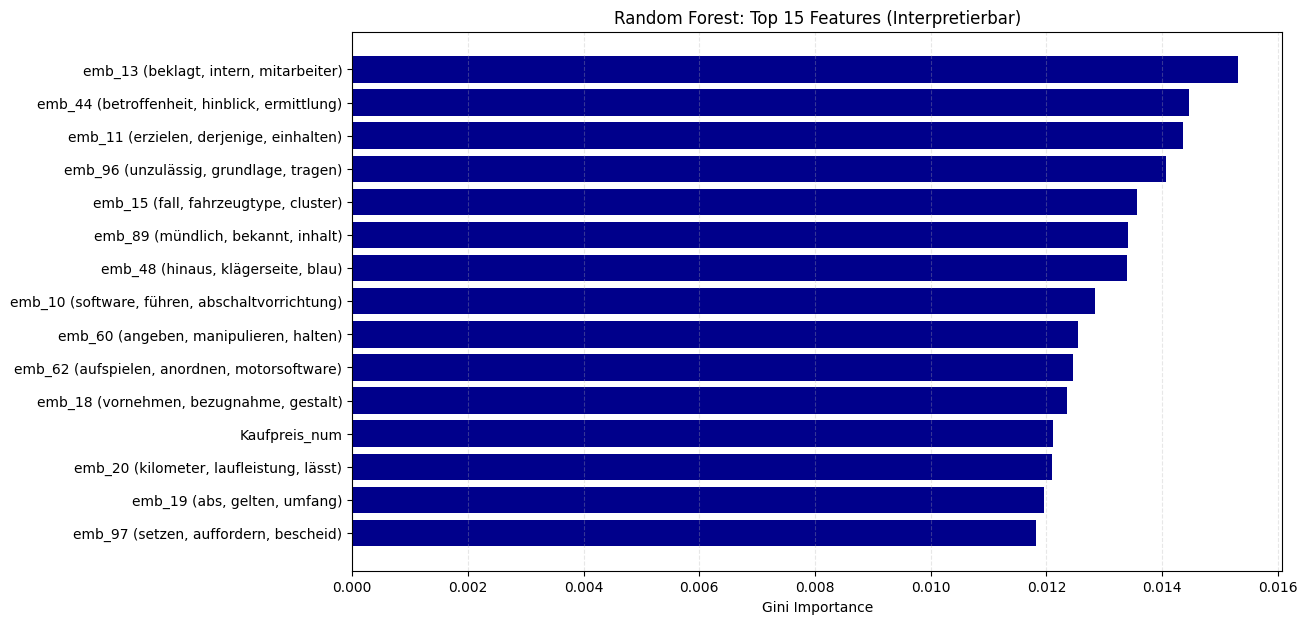

In [23]:
# Wir führen eine 5-fache Stratified Cross-Validation durch.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# 1. Sicherstellen, dass das CV-Objekt existiert
# Wir definieren k=5 hier noch einmal lokal zur Sicherheit
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Modell-Initialisierung
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, class_weight="balanced")

# 3. Cross-Validation (k=5)
scoring = ['accuracy', 'precision', 'recall', 'f1']
print("Starte Cross-Validation für Random Forest...")

# Wir nutzen cv_local statt cv, um den NameError zu vermeiden
cv_results_rf = cross_validate(rf_model, X_train_final, y_train, cv=cv_local, scoring=scoring)

# 4. Detaillierte Ausgabe der Folds
print("="*40)
print("ERGEBNISSE RANDOM FOREST: CROSS-VALIDATION")
print("="*40)
for i in range(5):
    print(f"Fold {i+1}:")
    print(f"  - Accuracy:  {cv_results_rf['test_accuracy'][i]:.4f}")
    print(f"  - Precision: {cv_results_rf['test_precision'][i]:.4f}")
    print(f"  - Recall:    {cv_results_rf['test_recall'][i]:.4f}")
    print("-" * 20)

print(f"\nMITTELWERTE ÜBER ALLE FOLDS:")
print(f"Mean Accuracy:  {cv_results_rf['test_accuracy'].mean():.4f} (+/- {cv_results_rf['test_accuracy'].std():.4f})")
print(f"Mean Precision: {cv_results_rf['test_precision'].mean():.4f}")
print(f"Mean Recall:    {cv_results_rf['test_recall'].mean():.4f}")

# 5. Finales Training & Feature Importance
rf_model.fit(X_train_final, y_train)

# Visualisierung mit Wort-Mapping (Nutzt die Funktion aus 6.0)
importances = rf_model.feature_importances_
feat_names = X_train_final.columns
top_indices = np.argsort(importances)[-15:]
top_importances = importances[top_indices]
top_names = [get_top_words_for_embedding(feat_names[i], w2v_model) for i in top_indices]

plt.figure(figsize=(12, 7))
plt.barh(top_names, top_importances, color='darkblue')
plt.title("Random Forest: Top 15 Features (Interpretierbar)")
plt.xlabel("Gini Importance")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.show()

### 6.3 Gradient Boosting

#### 6.3.1 Gradient Boosting ohne Hyperparameter-Tuning

In [24]:
# %% [markdown]
# ### 6.3 Gradient Boosting (Boosting)
# Evaluation der Modellstabilität mittels detaillierter CV-Statistiken.

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import classification_report

# 1. Sicherstellen, dass das CV-Objekt existiert
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Modell-Initialisierung
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# 3. Cross-Validation
scoring = ['accuracy', 'precision', 'recall', 'f1']
print("Starte Cross-Validation für Gradient Boosting...")
cv_results_gb = cross_validate(gb_model, X_train_final, y_train, cv=cv_local, scoring=scoring)

# 4. Detaillierte Ausgabe
print("="*40)
print("ERGEBNISSE GRADIENT BOOSTING: CROSS-VALIDATION")
print("="*40)
for i in range(5):
    print(f"Fold {i+1}: Accuracy {cv_results_gb['test_accuracy'][i]:.4f} | Recall {cv_results_gb['test_recall'][i]:.4f}")

print(f"\nMITTELWERTE:")
print(f"Mean Accuracy:  {cv_results_gb['test_accuracy'].mean():.4f}")
print(f"Mean F1-Score:  {cv_results_gb['test_f1'].mean():.4f}")

# 5. Finales Training & Evaluation auf Test-Set
gb_model.fit(X_train_final, y_train)
y_pred_gb = gb_model.predict(X_test_final)

print("\n" + "#"*40)
print("FINALER TESTSET-BERICHT (GRADIENT BOOSTING)")
print("#"*40)
print(classification_report(y_test, y_pred_gb))

Starte Cross-Validation für Gradient Boosting...
ERGEBNISSE GRADIENT BOOSTING: CROSS-VALIDATION
Fold 1: Accuracy 0.7614 | Recall 0.7647
Fold 2: Accuracy 0.7614 | Recall 0.7529
Fold 3: Accuracy 0.7102 | Recall 0.7059
Fold 4: Accuracy 0.7386 | Recall 0.7412
Fold 5: Accuracy 0.7045 | Recall 0.7059

MITTELWERTE:
Mean Accuracy:  0.7352
Mean F1-Score:  0.7281

########################################
FINALER TESTSET-BERICHT (GRADIENT BOOSTING)
########################################
              precision    recall  f1-score   support

           0       0.77      0.71      0.74       114
           1       0.71      0.77      0.74       106

    accuracy                           0.74       220
   macro avg       0.74      0.74      0.74       220
weighted avg       0.74      0.74      0.74       220



#### 6.3.2 Visualisierung Gradient Boosting ohne Tuning

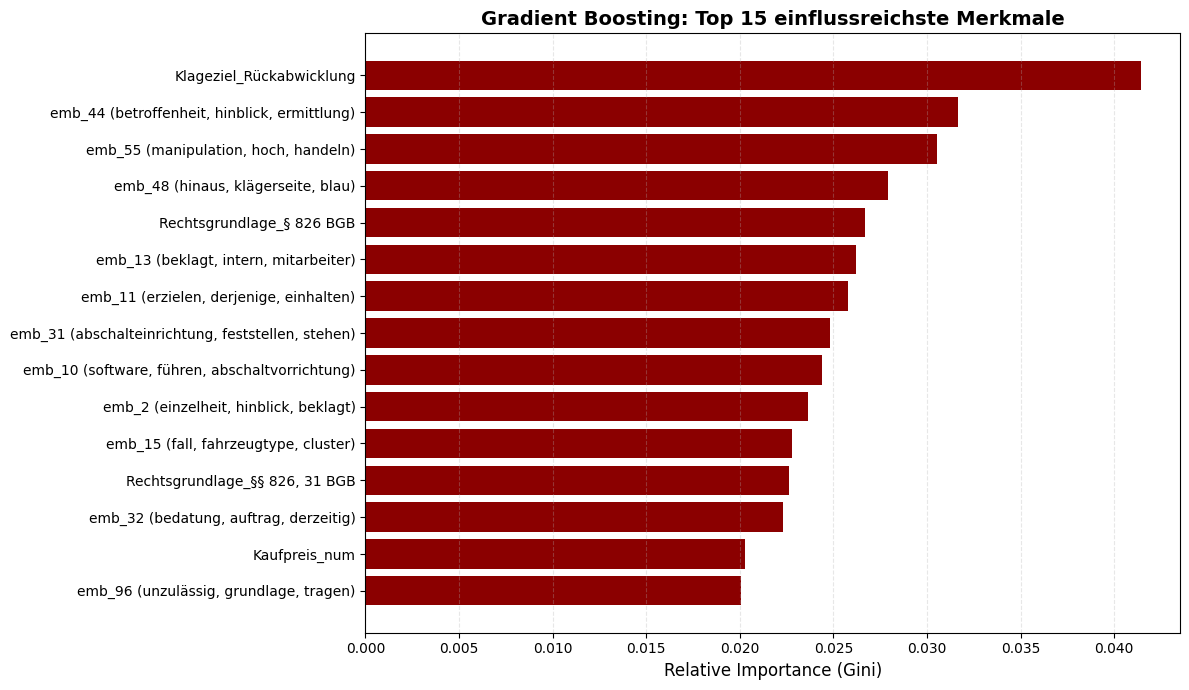

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Feature Importance aus dem Gradient Boosting Modell extrahieren
importances_gb = gb_model.feature_importances_
feat_names = X_train_final.columns

# 2. Top 15 Merkmale identifizieren
top_indices_gb = np.argsort(importances_gb)[-15:]
top_importances_gb = importances_gb[top_indices_gb]

# 3. Namen mappen: Wir nutzen die Funktion aus 6.0, um die Embeddings zu "übersetzen"
top_names_gb = [get_top_words_for_embedding(feat_names[i], w2v_model) for i in top_indices_gb]

# 4. Visualisierung
plt.figure(figsize=(12, 7))
plt.barh(top_names_gb, top_importances_gb, color='darkred')

# Styling-Elemente
plt.title("Gradient Boosting: Top 15 einflussreichste Merkmale", fontsize=14, fontweight='bold')
plt.xlabel("Relative Importance (Gini)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Damit die langen Namen der Wort-Mappigs nicht abgeschnitten werden:
plt.tight_layout()

# Grafik anzeigen
plt.show()

### 6.3.3 Gradient Boosting mit Hyperparameter-Tuning

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report

# 1. Setup
cv_local = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['accuracy', 'recall', 'f1']

# Basis-Modell mit Early Stopping
gb_base = GradientBoostingClassifier(
    n_estimators=420,
    n_iter_no_change=30,
    # validation_fraction=0.1,
    random_state=42
)

# Suchraum
param_grid = {
    'max_depth': [3, 4],
    'learning_rate': [0.01, 0.05],
    'subsample': [0.8, 0.9]
}

# 2. Suche starten
print("Starte GridSearchCV (Tuning)...")
grid_search = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    cv=cv_local,
    scoring='f1',
    n_jobs=-1
)
grid_search.fit(X_train_final, y_train)

# 3. Das beste Modell isolieren
best_gb_model = grid_search.best_estimator_

# 4. NEU: Detaillierte Validierung der Folds für das beste Modell
print("\n" + "="*45)
print("ANALYSE DER BESTEN PARAMETER")
print(f"Parameter: {grid_search.best_params_}")
print("="*45)

# Wir führen eine explizite Cross-Validation für die Gewinner-Konfiguration durch
cv_results_final = cross_validate(
    best_gb_model, X_train_final, y_train, 
    cv=cv_local, 
    scoring=scoring_metrics
)

# Einzelausgabe der Folds
for i in range(len(cv_results_final['test_accuracy'])):
    print(f"Fold {i+1}:")
    print(f"  - Accuracy: {cv_results_final['test_accuracy'][i]:.4f}")
    print(f"  - Recall:   {cv_results_final['test_recall'][i]:.4f}")
    print(f"  - F1-Score: {cv_results_final['test_f1'][i]:.4f}")
    print("-" * 25)

print(f"\nMITTELWERT ÜBER ALLE FOLDS (BEST MODEL):")
print(f"Mean Accuracy: {cv_results_final['test_accuracy'].mean():.4f} (+/- {cv_results_final['test_accuracy'].std():.4f})")
print(f"Mean Recall:   {cv_results_final['test_recall'].mean():.4f}")

# 5. Abschlussbericht auf dem Test-Set
print("\n" + "#"*45)
print("FINALER TESTSET-BERICHT (BLIND-TEST)")
print("#"*45)
y_pred_gb_opt = best_gb_model.predict(X_test_final)
print(classification_report(y_test, y_pred_gb_opt))

# 6. Baum-Statistik
print(f"Info: Das Modell nutzte {len(best_gb_model.estimators_)} Bäume.")

Starte GridSearchCV (Tuning)...



ANALYSE DER BESTEN PARAMETER
Parameter: {'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8}
Fold 1:
  - Accuracy: 0.7500
  - Recall:   0.7647
  - F1-Score: 0.7471
-------------------------
Fold 2:
  - Accuracy: 0.7841
  - Recall:   0.7647
  - F1-Score: 0.7738
-------------------------
Fold 3:
  - Accuracy: 0.7273
  - Recall:   0.7294
  - F1-Score: 0.7209
-------------------------
Fold 4:
  - Accuracy: 0.7216
  - Recall:   0.7294
  - F1-Score: 0.7168
-------------------------
Fold 5:
  - Accuracy: 0.6932
  - Recall:   0.6706
  - F1-Score: 0.6786
-------------------------

MITTELWERT ÜBER ALLE FOLDS (BEST MODEL):
Mean Accuracy: 0.7352 (+/- 0.0304)
Mean Recall:   0.7318

#############################################
FINALER TESTSET-BERICHT (BLIND-TEST)
#############################################
              precision    recall  f1-score   support

           0       0.78      0.74      0.76       114
           1       0.73      0.77      0.75       106

    accuracy           

#### 6.3.4 

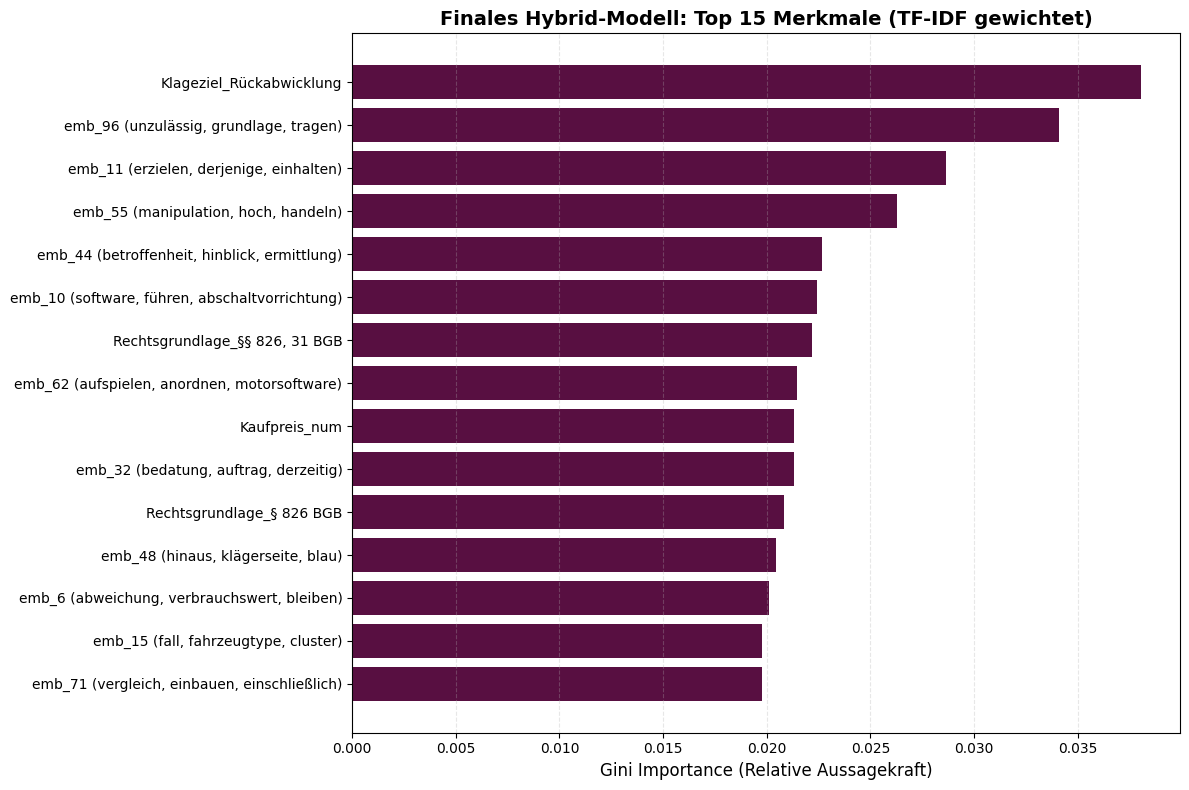

💡 Team-Lead Checkliste für die Interpretation:
1. Ist 'Klageziel_Rückabwicklung' ein strukturelles Feature (wie Kaufpreis) oder ein Text-Embedding?
2. Tauchen in den Klammern Begriffe auf, die spezifisch für Schadensersatz sind (z.B. 'sittenwidrig', 'unzulässig')?


In [28]:
# Durch die TF-IDF-Gewichtung repräsentieren diese Features nun die juristisch 
# relevantesten Begriffe im Verhältnis zu ihrer Bedeutung im Gesamtkorpus.

import numpy as np
import matplotlib.pyplot as plt

# 1. Feature Importances aus dem optimierten Modell (best_gb_model)
importances_final = best_gb_model.feature_importances_
feature_names = X_train_final.columns

# 2. Top 15 Indizes ermitteln
indices_final = np.argsort(importances_final)[-15:]

# 3. Werte und interpretierbare Labels extrahieren
top_values_final = importances_final[indices_final]
top_labels_final = [get_top_words_for_embedding(feature_names[i], w2v_model) for i in indices_final]

# 4. Visualisierung in Beeren-Lila (#580f41)
plt.figure(figsize=(12, 8))
plt.barh(top_labels_final, top_values_final, color='#580f41') 

# Styling
plt.title("Finales Hybrid-Modell: Top 15 Merkmale (TF-IDF gewichtet)", fontsize=14, fontweight='bold')
plt.xlabel("Gini Importance (Relative Aussagekraft)", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Layout-Anpassung für die langen Wort-Labels
plt.tight_layout()
plt.show()

print("💡 Team-Lead Checkliste für die Interpretation:")
print(f"1. Ist '{top_labels_final[-1]}' ein strukturelles Feature (wie Kaufpreis) oder ein Text-Embedding?")
print("2. Tauchen in den Klammern Begriffe auf, die spezifisch für Schadensersatz sind (z.B. 'sittenwidrig', 'unzulässig')?")

#### Analyse einzelner embeddings

In [29]:
# %% [markdown]
# ### 6.5 Discovery: Suche nach weiteren Stoppwort-Kandidaten
# Wir analysieren die Top 5 Embedding-Features des Modells.

# 1. Top Embedding-Features identifizieren (ohne strukturelle Features)
importances = best_gb_model.feature_importances_
feat_names = X_train_final.columns

# Nur 'emb_' Features filtern
emb_indices = [i for i, name in enumerate(feat_names) if name.startswith("emb_")]
emb_importances = importances[emb_indices]
top_emb_indices = np.array(emb_indices)[np.argsort(emb_importances)[-100:]]

print("ANALYSE DER TOP 100 TEXT-DIMENSIONEN:")
print("="*50)

for idx in reversed(top_emb_indices):
    feat_name = feat_names[idx]
    # Wir nutzen die Funktion aus 6.0, aber mit 15 Wörtern für mehr Durchblick
    words = get_top_words_for_embedding(feat_name, w2v_model, top_n=15)
    print(f"Feature {words}")
    print("-" * 50)

ANALYSE DER TOP 100 TEXT-DIMENSIONEN:
Feature emb_96 (unzulässig, grundlage, tragen, relevant, ausgehen, aufgrund, fahrkurvenerkennung, streitig, treffen, unbegründet, diesel, überprüfung, thermofenster, bestreiten, intern)
--------------------------------------------------
Feature emb_11 (erzielen, derjenige, einhalten, fahrbedingung, hingegen, überschreiten, straßenverkehr, gering, emissionswerte, stickoxidwert, datenblatt, vergeben, stickoxidgrenzwert, testbetrieb, gesetzlich)
--------------------------------------------------
Feature emb_55 (manipulation, hoch, handeln, reduzieren, verbrauch, rücktritt, außentemperatur, schnell, funktionieren, teilweise, bestimmt, steigen, melden, modus, bezeichnet)
--------------------------------------------------
Feature emb_44 (betroffenheit, hinblick, ermittlung, jahr, spätestens, verfahren, oberlandesgericht, ablauf, gegenstand, öffentlichkeit, verjährung, individuell, herbst, erhebung, nichtwissen)
-------------------------------------------

evtl. SHAP Werte für Erklärbarkeit